In [15]:
import json
from collections import defaultdict

import torch
from transformers import AutoTokenizer, AutoModel


SAVE_PATH = "./results.json"


name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModel.from_pretrained(name).to("cpu")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# gather all output LayerNorms weights and biases
values = {"weights": [], "biases": []}
weights, biases = [], []
for roberta_layer in model.encoder.layer:
    the_layer = roberta_layer.output.LayerNorm
    values["weights"].append(the_layer.weight)
    values["biases"].append(the_layer.bias)
values["weights"] = torch.stack(values["weights"])
values["biases"] = torch.stack(values["biases"])

In [7]:
# compute mean and std of gathered values
statistics = {
    key: {
        "mean": val.mean(),
        "std": val.std(),
    }
    for key, val in values.items()
}

In [8]:
# find outlier dimensions and compute distances from the mean

# # set hyperparameters for getting outlier dimensions
sigma_factor = 2
out_count_thres = 4

# # get outlier dimensions
param_outliers = {}
param_distance_from_mean = {}
param_relative_distance_from_mean = {}
for param in values:
    distance_from_mean = (values[param] - statistics[param]["mean"]).abs()
    std = statistics[param]["std"]
    out_count = (distance_from_mean > (sigma_factor * std)).int().sum(dim=0)
    outliers_mask = out_count >= out_count_thres

    outliers_idcs = torch.arange(len(outliers_mask))[outliers_mask]
    param_outliers[param] = list(outliers_idcs.numpy())
    param_distance_from_mean[param] = distance_from_mean.mean(dim=0)[outliers_idcs]
    param_relative_distance_from_mean[param] = distance_from_mean.mean(dim=0)[outliers_idcs] / (sigma_factor * std.mean(dim=0))

In [9]:
# number of ods for weight and biases
for param in param_outliers:
    print(param, len(param_outliers[param]))

weights 45
biases 19


In [10]:
# intersection of ods for each param -> it give us real ods we are going to work with
intersection = set(param_outliers["weights"]).intersection(set(param_outliers["biases"]))
print(f"{len(intersection) = }")
print(f"{intersection = }")

len(intersection) = 17
intersection = {97, 453, 551, 361, 330, 588, 77, 749, 494, 240, 496, 82, 498, 217, 219, 61, 731}


In [11]:
outlier_dimensions = sorted(list(intersection))
print(f"{outlier_dimensions = }")

outlier_dimensions = [61, 77, 82, 97, 217, 219, 240, 330, 361, 453, 494, 496, 498, 551, 588, 731, 749]


In [20]:
result = defaultdict(lambda: defaultdict(dict)) # od -> param(weights or biases) -> distance_type(absolute or relative) -> distance
for od in outlier_dimensions:
    for param, outliers in param_outliers.items():
        idx = outliers.index(od)
        result[int(od)][param]["absolute"] = param_distance_from_mean[param][idx].item()
        result[int(od)][param]["relative"] = param_relative_distance_from_mean[param][idx].item()


In [21]:
# save results
with open(SAVE_PATH, "w") as file:
    json.dump(result, file, indent=4)

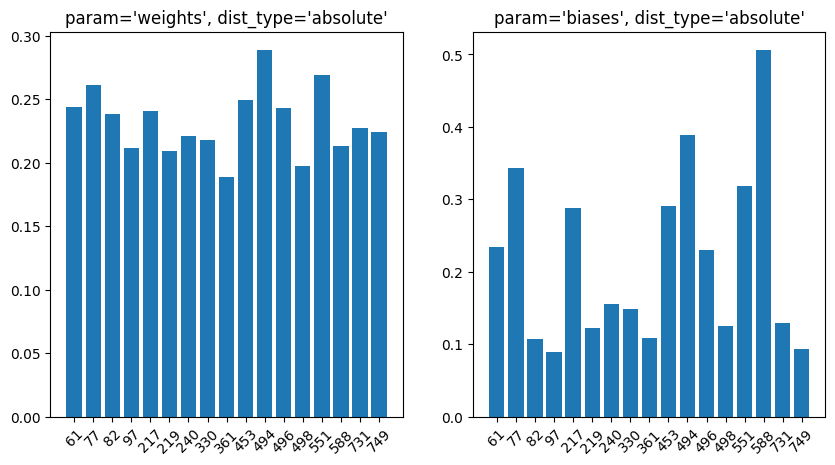

In [46]:
# visualize ods importance wrt found distances
import matplotlib.pyplot as plt

outlier_dimensions = sorted(list(result.keys()))
names = [f"{od}" for od in outlier_dimensions]

params = ["weights", "biases"]
dist_types = ["absolute"]

_, axes = plt.subplots(nrows=len(dist_types), ncols=len(params), figsize=(len(params)*5, len(dist_types)*5))
if axes.ndim == 1:
    axes = [axes]

for i, dist_type in enumerate(dist_types):
    for j, param in enumerate(params):
        distances = [result[od][param][dist_type] for od in outlier_dimensions]

        ax = axes[i][j]
        ax.bar(names, distances)
        ax.tick_params(axis='x', rotation=45)
        ax.set_title(f"{param=}, {dist_type=}")